In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import mne
import sgcd.config as config
from mne.stats import permutation_cluster_1samp_test
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import scipy

Overview:


1. Plot object decoding
2. Plot phrase decoding
3. Plot scene decoding
4. Plot anchor vs local decoding
5. Plot cross-decoding phrase
6. Plot cross-decoding scene
7. Plot confusion matrices

In [2]:
def compute_p_values(diff, return_clusters=False):
    t_obs, clusters, cluster_pv, H0 = clu = permutation_cluster_1samp_test(diff, n_permutations=10000, out_type="indices",tail=1)

    good_clusters_idx = np.where(cluster_pv < 0.05)[0]
    good_clusters = [clusters[idx] for idx in good_clusters_idx]

    pvals_plot = np.full((diff.shape[1]), None)
    for c in good_clusters:
        pvals_plot[c] = -2
    if return_clusters:
        return pvals_plot, good_clusters
    else:
        return pvals_plot

def smooth_for_plot(diff):    
    ga_scores = np.mean(np.array(diff*100), axis=0)
    sigma = scipy.stats.sem(np.array(diff*100), axis=0)

    # smoothing
    ga_scores = scipy.ndimage.gaussian_filter(ga_scores,2)
    sigma = scipy.ndimage.gaussian_filter(sigma,2)
    return ga_scores, sigma

def plot_arrays_and_scores(arrays, smooth_scores, epochs, colors, markers, colors_p=None):
    fig, (ax_main, ax_sub) = plt.subplots(2, 1, figsize=(10, 6), gridspec_kw={'height_ratios': [6, 1]})
    
    x_positions = np.linspace(-0.1, 1, len(arrays[0]))
    for i, (array, (smooth_score, sigma), color, marker) in enumerate(zip(arrays, smooth_scores, colors, markers)):
        ax_main.plot(epochs.times, smooth_score, color=color, linestyle=marker)
        ax_main.fill_between(epochs.times, smooth_score + sigma, smooth_score - sigma, facecolor=color, alpha=0.2)
        if array is None:
            continue
        x_sub = np.arange(len(array))
        y_sub = np.full_like(array, -i * 0.8)
        x_normalized = np.interp(x_sub, (x_sub.min(), x_sub.max()), (-0.1, 1))
        if colors_p is None:
            ax_sub.scatter(x_normalized, y_sub, c=[color if v is not None else 'white' for v in array], s=3)
        else:
            ax_sub.scatter(x_normalized, y_sub, c=[colors_p[i] if v is not None else 'white' for v in array], s=3)
    
    ax_main.axhline(0, color='k', linestyle='--', label='chance', linewidth=.8)
    ax_main.axvline(.0, color='k', linestyle='-', linewidth=.8)
    ax_main.axvline(.5, color='k', linestyle='-', linewidth=.8)
    ax_main.set_ylabel("% decoding accuracy above chance", fontsize=10)
    ax_main.spines['top'].set_visible(False)
    ax_main.spines['right'].set_visible(False)
    ax_main.set_xticks(np.linspace(-0.1, 1, 12))
    
    ax_sub.set_xlabel("time (s)")
    ax_sub.spines['top'].set_visible(False)
    ax_sub.spines['right'].set_visible(False)
    ax_sub.set_xlim(ax_main.get_xlim())
    ax_sub.set_xticks(np.linspace(-0.1, 1, 12))
    ax_sub.set_yticklabels([''] * len(arrays))
    
    ax_main.margins(x=0)
    ax_sub.set_xlim(-0.1, 1)
    
    return fig, ax_main, ax_sub



Load epochs for single subject to access epochs.times at any time

In [3]:
epochs = mne.read_epochs('../'+config.eeg_data_dir+f'sub-{str(1).zfill(2)}/eeg/sub-{str(1).zfill(2)}_repaired-True-epo.fif', verbose="warning")

Select which configuration to plot

In [4]:
estimator = 'SVM'
pca = True

### 1. Object Decoding

In [5]:
cond = "object"
objects = "all"

scores = []
for sub in range(25):
    fname = f'../data/sub-{str(sub+1).zfill(2)}/decoding/{estimator}/{cond}/{objects}/pca_{pca}/{str(sub+1).zfill(2)}-{cond}_{objects}-Decoding-Acc-pseudo-loeo-PCA_{pca}-{estimator}.npy'
    scores.append(np.load(fname))
scores = np.stack(scores)
diff = scores-1/8
pvals_plot, c_all = compute_p_values(diff, return_clusters=True)

cond = "object"
objects = "anchor"

scores_anc = []
for sub in range(25):
    fname = f'../data/sub-{str(sub+1).zfill(2)}/decoding/{estimator}/{cond}/{objects}/pca_{pca}/{str(sub+1).zfill(2)}-{cond}_{objects}-Decoding-Acc-pseudo-loeo-PCA_{pca}-{estimator}.npy'
    scores_anc.append(np.load(fname))
scores_anc = np.stack(scores_anc)
diff_anc = scores_anc-1/4
pvals_plot_anc, c_anc = compute_p_values(diff_anc,return_clusters=True)

cond = "object"
objects = "local"

scores_loc = []
for sub in range(25):
    fname = f'../data/sub-{str(sub+1).zfill(2)}/decoding/{estimator}/{cond}/{objects}/pca_{pca}/{str(sub+1).zfill(2)}-{cond}_{objects}-Decoding-Acc-pseudo-loeo-PCA_{pca}-{estimator}.npy'
    scores_loc.append(np.load(fname))
scores_loc = np.stack(scores_loc)
diff_loc = scores_loc-1/4
pvals_plot_loc,c_loc = compute_p_values(diff_loc,return_clusters=True)


Using a threshold of 1.710882
stat_fun(H1): min=-2.794842662984074 max=11.632692148734053


Running initial clustering …
Found 13 clusters


  0%|          | Permuting : 0/9999 [00:00<?,       ?it/s]

Using a threshold of 1.710882
stat_fun(H1): min=-1.6081688022566925 max=8.047409950811906
Running initial clustering …
Found 18 clusters


  0%|          | Permuting : 0/9999 [00:00<?,       ?it/s]

Using a threshold of 1.710882
stat_fun(H1): min=-2.039324585578018 max=8.133791880166442
Running initial clustering …
Found 16 clusters


  0%|          | Permuting : 0/9999 [00:00<?,       ?it/s]

In [7]:
# significant clusters
[epochs.times[x] for x in c_anc] 

[array([0.132, 0.136, 0.14 , 0.144, 0.148, 0.152, 0.156, 0.16 , 0.164,
        0.168, 0.172, 0.176, 0.18 , 0.184, 0.188, 0.192, 0.196, 0.2  ,
        0.204, 0.208, 0.212, 0.216, 0.22 , 0.224, 0.228, 0.232, 0.236,
        0.24 , 0.244, 0.248, 0.252, 0.256, 0.26 , 0.264, 0.268, 0.272,
        0.276, 0.28 , 0.284, 0.288, 0.292, 0.296, 0.3  , 0.304, 0.308,
        0.312, 0.316, 0.32 , 0.324, 0.328, 0.332, 0.336, 0.34 , 0.344,
        0.348, 0.352, 0.356, 0.36 , 0.364, 0.368, 0.372, 0.376, 0.38 ,
        0.384, 0.388, 0.392, 0.396, 0.4  , 0.404, 0.408, 0.412, 0.416,
        0.42 , 0.424, 0.428, 0.432, 0.436, 0.44 , 0.444, 0.448, 0.452,
        0.456, 0.46 , 0.464, 0.468, 0.472, 0.476, 0.48 , 0.484, 0.488,
        0.492, 0.496, 0.5  , 0.504, 0.508, 0.512, 0.516, 0.52 , 0.524,
        0.528, 0.532, 0.536, 0.54 , 0.544, 0.548, 0.552]),
 array([0.676, 0.68 , 0.684, 0.688, 0.692, 0.696, 0.7  , 0.704, 0.708,
        0.712, 0.716, 0.72 , 0.724, 0.728, 0.732, 0.736])]

/var/folders/8j/h8w6skpx111fc1wp64yw19kw0000gn/T/ipykernel_26644/1020555934.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_sub.set_yticklabels([''] * len(arrays))


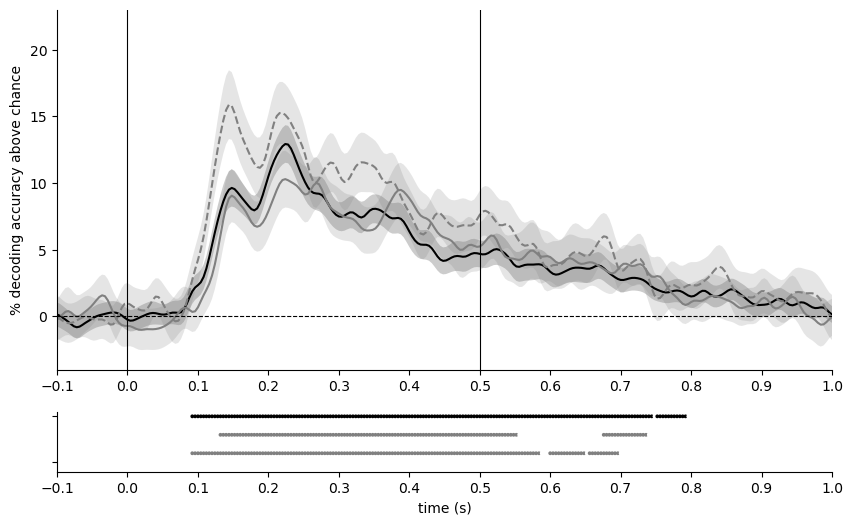

In [230]:
colors = ['black','grey','grey']
markers = ['-','-','--']
arrays = [pvals_plot, pvals_plot_anc, pvals_plot_loc]
smooth_scores = [smooth_for_plot(diff), smooth_for_plot(diff_anc), smooth_for_plot(diff_loc)]
fig, ax_main, ax_sub = plot_arrays_and_scores(arrays, smooth_scores, epochs, colors, markers)
plt.yticks(ticks=range(-4, 8, 2))
ax_main.set_ylim(top=23, bottom=-4)
ax_sub.set_ylim(-3*0.8,0.2)
plt.savefig(f'../results/plots/ObjectDecoding-PCA_{pca}-{estimator}_new.png', dpi=300)


### 2. Phrase Decoding

In [10]:
cond="phrase"
objects="all"
scores = []
for sub in range(25):
    fname = f'../data/sub-{str(sub+1).zfill(2)}/decoding/{estimator}/{cond}/{objects}/pca_{pca}/{str(sub+1).zfill(2)}-{cond}_{objects}-Decoding-Acc-pseudo-loeo-PCA_{pca}-{estimator}.npy'
    scores.append(np.load(fname))
scores = np.stack(scores)
diff = scores-1/4
pvals_plot,c_p = compute_p_values(diff,return_clusters=True)


Using a threshold of 1.710882
stat_fun(H1): min=-2.8312206336984485 max=8.461588086145015
Running initial clustering …
Found 16 clusters


  0%|          | Permuting : 0/9999 [00:00<?,       ?it/s]

In [11]:
# significant clusters
[epochs.times[x] for x in c_p]

[array([0.116, 0.12 , 0.124, 0.128, 0.132, 0.136, 0.14 , 0.144, 0.148,
        0.152, 0.156, 0.16 , 0.164, 0.168, 0.172, 0.176, 0.18 , 0.184,
        0.188, 0.192, 0.196, 0.2  , 0.204, 0.208, 0.212, 0.216, 0.22 ,
        0.224, 0.228, 0.232, 0.236, 0.24 , 0.244, 0.248, 0.252, 0.256,
        0.26 , 0.264, 0.268, 0.272, 0.276, 0.28 , 0.284, 0.288, 0.292,
        0.296, 0.3  , 0.304, 0.308, 0.312, 0.316, 0.32 , 0.324, 0.328,
        0.332, 0.336, 0.34 , 0.344, 0.348, 0.352, 0.356, 0.36 , 0.364,
        0.368, 0.372, 0.376, 0.38 , 0.384, 0.388, 0.392, 0.396, 0.4  ,
        0.404, 0.408, 0.412, 0.416, 0.42 , 0.424, 0.428, 0.432, 0.436,
        0.44 , 0.444, 0.448, 0.452, 0.456, 0.46 , 0.464, 0.468, 0.472,
        0.476, 0.48 , 0.484, 0.488, 0.492, 0.496, 0.5  , 0.504, 0.508,
        0.512, 0.516, 0.52 , 0.524, 0.528, 0.532, 0.536, 0.54 , 0.544,
        0.548, 0.552, 0.556, 0.56 , 0.564, 0.568, 0.572, 0.576, 0.58 ,
        0.584, 0.588, 0.592, 0.596]),
 array([0.604, 0.608, 0.612, 0.616, 0.6

/var/folders/8j/h8w6skpx111fc1wp64yw19kw0000gn/T/ipykernel_26644/1020555934.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_sub.set_yticklabels([''] * len(arrays))


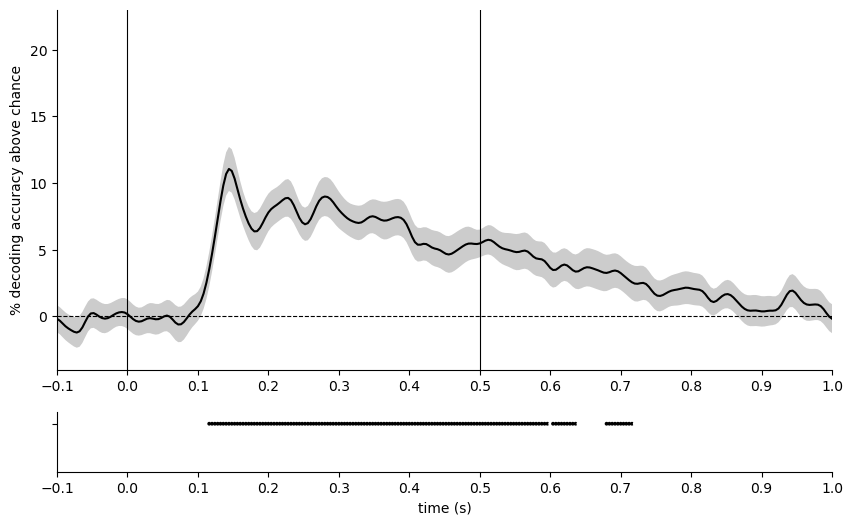

In [233]:
colors = ['black']
markers = ['-']
arrays = [pvals_plot]
smooth_scores = [smooth_for_plot(diff)]
fig, ax_main, ax_sub = plot_arrays_and_scores(arrays, smooth_scores, epochs, colors, markers)
plt.yticks(ticks=range(-4, 8, 2))
ax_main.set_ylim(top=23, bottom=-4)
ax_sub.set_ylim(-1*0.8,0.2)
plt.savefig(f'../results/plots/PhraseDecoding-PCA_{pca}-{estimator}_new.png', dpi=300)

### 3. Scene Decoding

In [12]:
cond="scene"

scores = []
for sub in range(25):
    fname = f'../data/sub-{str(sub+1).zfill(2)}/decoding/{estimator}/{cond}/{objects}/pca_{pca}/{str(sub+1).zfill(2)}-{cond}_{objects}-Decoding-Acc-pseudo-loeo-PCA_{pca}-{estimator}.npy'
    scores.append(np.load(fname))
scores = np.stack(scores)
diff = scores-1/2
pvals_plot,c_all = compute_p_values(diff,return_clusters=True)

objects="anchor"
scores_anc = []
for sub in range(25):
    fname = f'../data/sub-{str(sub+1).zfill(2)}/decoding/{estimator}/{cond}/{objects}/pca_{pca}/{str(sub+1).zfill(2)}-{cond}_{objects}-Decoding-Acc-pseudo-loeo-PCA_{pca}-{estimator}.npy'
    scores_anc.append(np.load(fname))
scores_anc = np.stack(scores_anc)
diff_anc = scores_anc-1/2
pvals_plot_anc, c_anc = compute_p_values(diff_anc, return_clusters=True)

objects="local"
scores_loc = []
for sub in range(25):
    fname = f'../data/sub-{str(sub+1).zfill(2)}/decoding/{estimator}/{cond}/{objects}/pca_{pca}/{str(sub+1).zfill(2)}-{cond}_{objects}-Decoding-Acc-pseudo-loeo-PCA_{pca}-{estimator}.npy'
    scores_loc.append(np.load(fname))
scores_loc = np.stack(scores_loc)
diff_loc = scores_loc-1/2
pvals_plot_loc,c_loc = compute_p_values(diff_loc,return_clusters=True)


Using a threshold of 1.710882
stat_fun(H1): min=-1.645314951939093 max=6.4018439966448
Running initial clustering …
Found 20 clusters


  0%|          | Permuting : 0/9999 [00:00<?,       ?it/s]

Using a threshold of 1.710882
stat_fun(H1): min=-2.2335896964052764 max=4.6263940983660845
Running initial clustering …
Found 31 clusters


  0%|          | Permuting : 0/9999 [00:00<?,       ?it/s]

Using a threshold of 1.710882
stat_fun(H1): min=-1.6909637717185766 max=4.992921660704142
Running initial clustering …
Found 25 clusters


  0%|          | Permuting : 0/9999 [00:00<?,       ?it/s]

In [15]:
# significant clusters
[epochs.times[x] for x in c_anc] # select configuration

[array([0.128, 0.132, 0.136, 0.14 , 0.144, 0.148, 0.152, 0.156, 0.16 ,
        0.164, 0.168, 0.172, 0.176, 0.18 , 0.184, 0.188, 0.192]),
 array([0.216, 0.22 , 0.224, 0.228, 0.232, 0.236, 0.24 , 0.244, 0.248,
        0.252]),
 array([0.364, 0.368, 0.372, 0.376, 0.38 , 0.384, 0.388, 0.392, 0.396,
        0.4  , 0.404, 0.408, 0.412, 0.416, 0.42 , 0.424, 0.428, 0.432,
        0.436, 0.44 , 0.444, 0.448, 0.452, 0.456, 0.46 , 0.464, 0.468,
        0.472, 0.476, 0.48 , 0.484])]

/var/folders/8j/h8w6skpx111fc1wp64yw19kw0000gn/T/ipykernel_26644/1020555934.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_sub.set_yticklabels([''] * len(arrays))


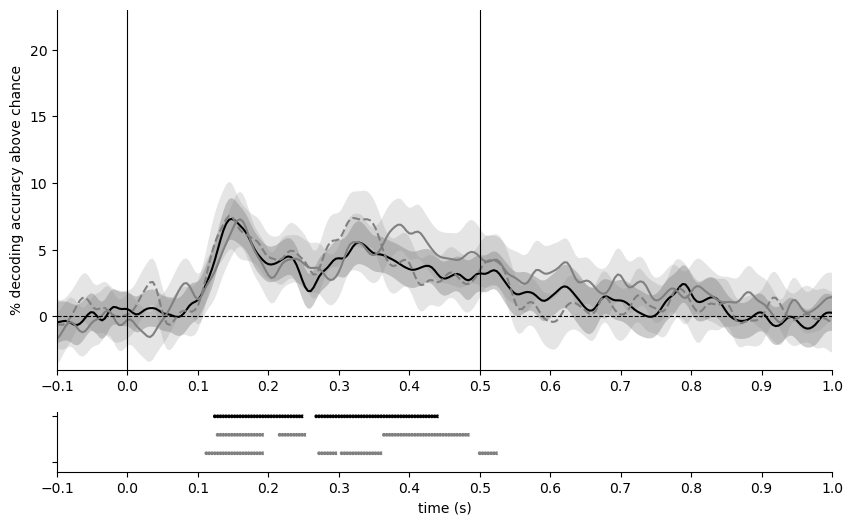

In [236]:
colors = ['black','grey','grey']
markers = ['-','-','--']
arrays = [pvals_plot, pvals_plot_anc, pvals_plot_loc]
smooth_scores = [smooth_for_plot(diff), smooth_for_plot(diff_anc), smooth_for_plot(diff_loc)]
fig, ax_main, ax_sub = plot_arrays_and_scores(arrays, smooth_scores, epochs, colors, markers)
plt.yticks(ticks=range(-4, 8, 2))
ax_main.set_ylim(top=23, bottom=-4)
ax_sub.set_ylim(-3*0.8,0.2)
plt.savefig(f'../results/plots/SceneDecoding-PCA_{pca}-{estimator}_new.png', dpi=300)

### 4. Anchor vs. Local decoding

In [16]:
cond="avl"
objects="all"
scores = []
for sub in range(25):
    fname = f'../data/sub-{str(sub+1).zfill(2)}/decoding/{estimator}/{cond}/{objects}/pca_{pca}/{str(sub+1).zfill(2)}-{cond}_{objects}-Decoding-Acc-pseudo-loeo-PCA_{pca}-{estimator}.npy'
    scores.append(np.load(fname))
scores = np.stack(scores)
diff = scores-1/2
pvals_plot,c_p = compute_p_values(diff,return_clusters=True)

Using a threshold of 1.710882
stat_fun(H1): min=-2.914191385259855 max=15.738686841630724
Running initial clustering …
Found 10 clusters


  0%|          | Permuting : 0/9999 [00:00<?,       ?it/s]

In [17]:
# significant clusters
[epochs.times[x] for x in c_p]

[array([0.088, 0.092, 0.096, 0.1  , 0.104, 0.108, 0.112, 0.116, 0.12 ,
        0.124, 0.128, 0.132, 0.136, 0.14 , 0.144, 0.148, 0.152, 0.156,
        0.16 , 0.164, 0.168, 0.172, 0.176, 0.18 , 0.184, 0.188, 0.192,
        0.196, 0.2  , 0.204, 0.208, 0.212, 0.216, 0.22 , 0.224, 0.228,
        0.232, 0.236, 0.24 , 0.244, 0.248, 0.252, 0.256, 0.26 , 0.264,
        0.268, 0.272, 0.276, 0.28 , 0.284, 0.288, 0.292, 0.296, 0.3  ,
        0.304, 0.308, 0.312, 0.316, 0.32 , 0.324, 0.328, 0.332, 0.336,
        0.34 , 0.344, 0.348, 0.352, 0.356, 0.36 , 0.364, 0.368, 0.372,
        0.376, 0.38 , 0.384, 0.388, 0.392, 0.396, 0.4  , 0.404, 0.408,
        0.412, 0.416, 0.42 , 0.424, 0.428, 0.432, 0.436, 0.44 , 0.444,
        0.448, 0.452, 0.456, 0.46 , 0.464, 0.468, 0.472, 0.476, 0.48 ,
        0.484, 0.488, 0.492, 0.496, 0.5  , 0.504, 0.508, 0.512, 0.516,
        0.52 , 0.524, 0.528, 0.532, 0.536, 0.54 , 0.544, 0.548, 0.552,
        0.556, 0.56 , 0.564, 0.568, 0.572, 0.576, 0.58 , 0.584, 0.588,
      

/var/folders/8j/h8w6skpx111fc1wp64yw19kw0000gn/T/ipykernel_26644/1020555934.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_sub.set_yticklabels([''] * len(arrays))


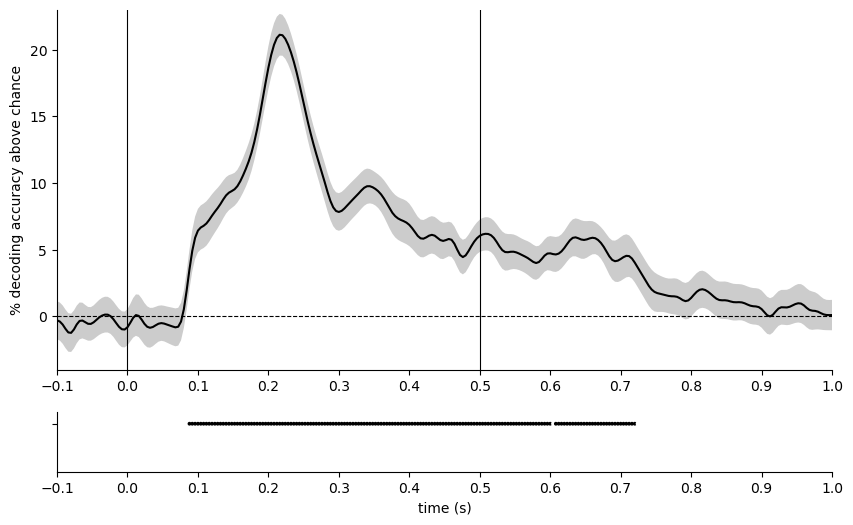

In [239]:
colors = ['black']
markers = ['-']
arrays = [pvals_plot]
smooth_scores = [smooth_for_plot(diff)]
fig, ax_main, ax_sub = plot_arrays_and_scores(arrays, smooth_scores, epochs, colors, markers)
plt.yticks(ticks=range(-4, 8, 2))
ax_main.set_ylim(top=23, bottom=-4)
ax_sub.set_ylim(-1*0.8,0.2)
plt.savefig(f'../results/plots/AnchorLocalDecoding-PCA_{pca}-{estimator}_new.png', dpi=300)

### 5. Cross-Decoding Phrase

In [10]:
# Anchor to local within phrase
direction_flag = "CrossAnchorLocal"
cond = "phrase"

# WITHIN PHRASE
# Anchor to local within phrase
scores = []
for sub in range(25):
    fname = f'../data/sub-{str(sub+1).zfill(2)}/cross_decoding/{direction_flag}/{cond}/{estimator}/pca_{pca}/{str(sub+1).zfill(2)}-{direction_flag}-Decoding-Acc-pseudo-diagtimes-PCA_{pca}-{estimator}.npy'
    scores.append(np.load(fname))
scores = np.stack(scores)
diff_al = scores-1/4
pvals_plot_al, c_al = compute_p_values(diff_al, return_clusters=True)
# save sig timepoints
[np.save(f"../results/good_clusters-al-diagtimes-PCA_{pca}-{estimator}-{x+1}.npy", c_al[x]) for x in range(len(c_al))]

# Local to anchor within phrase
direction_flag = "CrossLocalAnchor"
cond = "phrase"
scores = []
for sub in range(25):
    fname = f'../data/sub-{str(sub+1).zfill(2)}/cross_decoding/{direction_flag}/{cond}/{estimator}/pca_{pca}/{str(sub+1).zfill(2)}-{direction_flag}-Decoding-Acc-pseudo-diagtimes-PCA_{pca}-{estimator}.npy'
    scores.append(np.load(fname))
scores = np.stack(scores)
diff_la = scores-1/4
pvals_plot_la, c_la = compute_p_values(diff_la, return_clusters=True)
# safe sig timepoints
[np.save(f"../results/good_clusters-la-diagtimes-PCA_{pca}-{estimator}-{x+1}.npy", c_la[x]) for x in range(len(c_la))]

# BETWEEN PHRASE
# Anchor to local between phrase within scene
direction_flag = "CrossAnchorLocalDiffPhraseSameScene"
scores = []
for sub in range(25):
    fname = f'../data/sub-{str(sub+1).zfill(2)}/cross_decoding/{direction_flag}/{cond}/{estimator}/pca_{pca}/{str(sub+1).zfill(2)}-{direction_flag}-Decoding-Acc-pseudo-diagtimes-PCA_{pca}-{estimator}.npy'
    scores.append(np.load(fname))
scores = np.stack(scores)
diff_al_control_within_scene = scores-1/4
pvals_plot_al_control_within_scene = compute_p_values(diff_al_control_within_scene)

# Anchor to local between phrase between scene1
direction_flag = "CrossAnchorLocalDiffPhraseDiffScene"
scores_2 = []
for sub in range(25):
    fname = f'../data/sub-{str(sub+1).zfill(2)}/cross_decoding/{direction_flag}/{cond}/{estimator}/pca_{pca}/{str(sub+1).zfill(2)}-{direction_flag}-Decoding-Acc-pseudo-diagtimes-PCA_{pca}-{estimator}.npy'
    scores_2.append(np.load(fname))
scores_2 = np.stack(scores_2)

# Anchor to local between phrase between scene2
direction_flag = "CrossAnchorLocalDiffPhraseDiffScene2"
scores_3 = []
for sub in range(25):
    fname = f'../data/sub-{str(sub+1).zfill(2)}/cross_decoding/{direction_flag}/{cond}/{estimator}/pca_{pca}/{str(sub+1).zfill(2)}-{direction_flag}-Decoding-Acc-pseudo-diagtimes-PCA_{pca}-{estimator}.npy'
    scores_3.append(np.load(fname))
scores_3 = np.stack(scores_3)

scores = np.stack([scores_2,scores_3]).mean(axis=0)
diff_al_control_between_scene = scores-1/4
pvals_plot_al_control_between_scene = compute_p_values(diff_al_control_between_scene)

# Local to anchor between phrase within scene
direction_flag = "CrossLocalAnchorDiffPhraseSameScene"
scores = []
for sub in range(25):
    fname = f'../data/sub-{str(sub+1).zfill(2)}/cross_decoding/{direction_flag}/{cond}/{estimator}/pca_{pca}/{str(sub+1).zfill(2)}-{direction_flag}-Decoding-Acc-pseudo-diagtimes-PCA_{pca}-{estimator}.npy'
    scores.append(np.load(fname))
scores = np.stack(scores)
diff_la_control_within_scene = scores-1/4
pvals_plot_la_control_within_scene = compute_p_values(diff_la_control_within_scene)

# Local to anchor between phrase between scene1
direction_flag = "CrossLocalAnchorDiffPhraseDiffScene"
scores_2 = []
for sub in range(25):
    fname = f'../data/sub-{str(sub+1).zfill(2)}/cross_decoding/{direction_flag}/{cond}/{estimator}/pca_{pca}/{str(sub+1).zfill(2)}-{direction_flag}-Decoding-Acc-pseudo-diagtimes-PCA_{pca}-{estimator}.npy'
    scores_2.append(np.load(fname))
scores_2 = np.stack(scores_2)

# Local to anchor between phrase between scene2 
direction_flag = "CrossLocalAnchorDiffPhraseDiffScene2"
scores_3 = []
for sub in range(25):
    fname = f'../data/sub-{str(sub+1).zfill(2)}/cross_decoding/{direction_flag}/{cond}/{estimator}/pca_{pca}/{str(sub+1).zfill(2)}-{direction_flag}-Decoding-Acc-pseudo-diagtimes-PCA_{pca}-{estimator}.npy'
    scores_3.append(np.load(fname))
scores_3 = np.stack(scores_3)

scores = np.stack([scores_2,scores_3]).mean(axis=0)
diff_la_control_between_scene = scores-1/4
pvals_plot_la_control_between_scene = compute_p_values(diff_la_control_between_scene)

# difference al - al within scene control
diff_al_within = diff_al-diff_al_control_within_scene
pvals_plot_diff_al_within, c_d_al_within = compute_p_values(diff_al_within, return_clusters=True)
[np.save(f"../results/good_clusters-al_diff_within-diagtimes-PCA_{pca}-{estimator}-{x+1}.npy", c_d_al_within[x]) for x in range(len(c_d_al_within))]

# difference al - al between scene control
diff_al_between = diff_al-diff_al_control_between_scene
pvals_plot_diff_al_between, c_d_al_between = compute_p_values(diff_al_between, return_clusters=True)
[np.save(f"../results/good_clusters-al_diff_between-diagtimes-PCA_{pca}-{estimator}-{x+1}.npy", c_d_al_between[x]) for x in range(len(c_d_al_between))]

# difference la - la within scene control
diff_la_within = diff_la-diff_la_control_within_scene
pvals_plot_diff_la_within, c_d_la_within = compute_p_values(diff_la_within, return_clusters=True)
[np.save(f"../results/good_clusters-la_diff_within-diagtimes-PCA_{pca}-{estimator}-{x+1}.npy", c_d_la_within[x]) for x in range(len(c_d_la_within))]

# difference la - la between scene control
diff_la_between = diff_la-diff_la_control_between_scene
pvals_plot_diff_la_between, c_d_la_between = compute_p_values(diff_la_between, return_clusters=True)
[np.save(f"../results/good_clusters-la_diff_between-diagtimes-PCA_{pca}-{estimator}-{x+1}.npy", c_d_la_between[x]) for x in range(len(c_d_la_between))]

Using a threshold of 1.710882
stat_fun(H1): min=-2.3968818270657075 max=3.747230116679722
Running initial clustering …
Found 23 clusters


  0%|          | Permuting : 0/9999 [00:00<?,       ?it/s]

Using a threshold of 1.710882
stat_fun(H1): min=-2.8594852948423353 max=4.452831537726843
Running initial clustering …
Found 30 clusters


  0%|          | Permuting : 0/9999 [00:00<?,       ?it/s]

Using a threshold of 1.710882
stat_fun(H1): min=-3.2312671838294396 max=2.1904761904761907
Running initial clustering …
Found 8 clusters


  0%|          | Permuting : 0/9999 [00:00<?,       ?it/s]

Using a threshold of 1.710882
stat_fun(H1): min=-3.7782809518570546 max=2.250224244297277
Running initial clustering …
Found 3 clusters


  0%|          | Permuting : 0/9999 [00:00<?,       ?it/s]

Using a threshold of 1.710882
stat_fun(H1): min=-3.1983134500779133 max=2.699908693497572
Running initial clustering …
Found 5 clusters


  0%|          | Permuting : 0/9999 [00:00<?,       ?it/s]

Using a threshold of 1.710882
stat_fun(H1): min=-3.413280743931444 max=3.269695565478398
Running initial clustering …
Found 6 clusters


  0%|          | Permuting : 0/9999 [00:00<?,       ?it/s]

Using a threshold of 1.710882
stat_fun(H1): min=-2.4014962076748563 max=3.4970860786382234
Running initial clustering …
Found 14 clusters


  0%|          | Permuting : 0/9999 [00:00<?,       ?it/s]

Using a threshold of 1.710882
stat_fun(H1): min=-2.570860912609325 max=3.681342557470631
Running initial clustering …
Found 25 clusters


  0%|          | Permuting : 0/9999 [00:00<?,       ?it/s]

Using a threshold of 1.710882
stat_fun(H1): min=-2.9616842512430175 max=4.220714748675953
Running initial clustering …
Found 23 clusters


  0%|          | Permuting : 0/9999 [00:00<?,       ?it/s]

Using a threshold of 1.710882
stat_fun(H1): min=-3.1256144955101433 max=4.258325179379018
Running initial clustering …
Found 31 clusters


  0%|          | Permuting : 0/9999 [00:00<?,       ?it/s]

[None, None, None]

In [11]:
print(f'significant clusters al difference within: {[epochs.times[x] for x in c_d_al_within]}',
    f'\nsignificant clusters al difference between: {[epochs.times[x] for x in c_d_al_between]}',
    f'\nsignificant clusters la difference within: {[epochs.times[x] for x in c_d_la_within]}',
    f'\nsignificant clusters la difference between: {[epochs.times[x] for x in c_d_la_between]}')

significant clusters al difference within: [array([0.128, 0.132, 0.136, 0.14 , 0.144, 0.148, 0.152, 0.156, 0.16 ,
       0.164]), array([0.248, 0.252, 0.256, 0.26 , 0.264, 0.268, 0.272, 0.276, 0.28 ,
       0.284])] 
significant clusters al difference between: [array([0.128, 0.132, 0.136, 0.14 , 0.144, 0.148, 0.152, 0.156, 0.16 ,
       0.164])] 
significant clusters la difference within: [array([0.14 , 0.144, 0.148, 0.152, 0.156]), array([0.256, 0.26 , 0.264, 0.268, 0.272, 0.276, 0.28 ])] 
significant clusters la difference between: [array([0.132, 0.136, 0.14 , 0.144, 0.148]), array([0.164, 0.168, 0.172, 0.176]), array([0.524, 0.528, 0.532, 0.536])]


Between phrase within scene vs. between phrase between scene

In [12]:
# Anchor to local within phrase
direction_flag = "CrossAnchorLocal"
cond = "phrase"
scores = []
for sub in range(25):
    fname = f'../data/sub-{str(sub+1).zfill(2)}/cross_decoding/{direction_flag}/{cond}/{estimator}/pca_{pca}/{str(sub+1).zfill(2)}-{direction_flag}-Decoding-Acc-pseudo-diagtimes-PCA_{pca}-{estimator}.npy'
    scores.append(np.load(fname))
scores_al_within_1 = np.stack(scores)

# Anchor to local between phrase within scene
direction_flag = "CrossAnchorLocalDiffPhraseSameScene"
scores_within = []
for sub in range(25):
    fname = f'../data/sub-{str(sub+1).zfill(2)}/cross_decoding/{direction_flag}/{cond}/{estimator}/pca_{pca}/{str(sub+1).zfill(2)}-{direction_flag}-Decoding-Acc-pseudo-diagtimes-PCA_{pca}-{estimator}.npy'
    scores_within.append(np.load(fname))
scores_al_within_2 = np.stack(scores)
scores_al_within = np.stack([scores_al_within_1,scores_al_within_2]).mean(axis=0)-1/4

# Anchor to local between phrase between scene1
direction_flag = "CrossAnchorLocalDiffPhraseDiffScene"
scores_2 = []
for sub in range(25):
    fname = f'../data/sub-{str(sub+1).zfill(2)}/cross_decoding/{direction_flag}/{cond}/{estimator}/pca_{pca}/{str(sub+1).zfill(2)}-{direction_flag}-Decoding-Acc-pseudo-diagtimes-PCA_{pca}-{estimator}.npy'
    scores_2.append(np.load(fname))
scores_2 = np.stack(scores_2)

# Anchor to local between phrase between scene2
direction_flag = "CrossAnchorLocalDiffPhraseDiffScene2"
scores_3 = []
for sub in range(25):
    fname = f'../data/sub-{str(sub+1).zfill(2)}/cross_decoding/{direction_flag}/{cond}/{estimator}/pca_{pca}/{str(sub+1).zfill(2)}-{direction_flag}-Decoding-Acc-pseudo-diagtimes-PCA_{pca}-{estimator}.npy'
    scores_3.append(np.load(fname))
scores_3 = np.stack(scores_3)
scores_between = np.stack([scores_2,scores_3]).mean(axis=0)
diff_al_between = scores_between-1/4

diff_al_scene = diff_al_within-diff_al_between
pvals_al_scene, c_d_al_scene = compute_p_values(diff_al_scene, return_clusters=True)

# local to anchor between phrase within scene
direction_flag = "CrossLocalAnchorDiffPhraseSameScene"
scores = []
for sub in range(25):
    fname = f'../data/sub-{str(sub+1).zfill(2)}/cross_decoding/{direction_flag}/{cond}/{estimator}/pca_{pca}/{str(sub+1).zfill(2)}-{direction_flag}-Decoding-Acc-pseudo-diagtimes-PCA_{pca}-{estimator}.npy'
    scores.append(np.load(fname))
scores = np.stack(scores)
diff_la_within_scene = scores-1/4

# local to anchor between phrase between scene1
direction_flag = "CrossLocalAnchorDiffPhraseDiffScene"
scores_2 = []
for sub in range(25):
    fname = f'../data/sub-{str(sub+1).zfill(2)}/cross_decoding/{direction_flag}/{cond}/{estimator}/pca_{pca}/{str(sub+1).zfill(2)}-{direction_flag}-Decoding-Acc-pseudo-diagtimes-PCA_{pca}-{estimator}.npy'
    scores_2.append(np.load(fname))
scores_2 = np.stack(scores_2)

# local to anchor between phrase between scene2
direction_flag = "CrossLocalAnchorDiffPhraseDiffScene2"
scores_3 = []
for sub in range(25):
    fname = f'../data/sub-{str(sub+1).zfill(2)}/cross_decoding/{direction_flag}/{cond}/{estimator}/pca_{pca}/{str(sub+1).zfill(2)}-{direction_flag}-Decoding-Acc-pseudo-diagtimes-PCA_{pca}-{estimator}.npy'
    scores_3.append(np.load(fname))
scores_3 = np.stack(scores_3)

scores_between = np.stack([scores_2,scores_3]).mean(axis=0)
diff_la_between = scores_between-1/4

diff_la_scene = diff_la_within-diff_la_between
pvals_la_scene, c_d_la_scene = compute_p_values(diff_la_scene, return_clusters=True)

Using a threshold of 1.710882
stat_fun(H1): min=-3.5529391527827534 max=2.7282410027474038
Running initial clustering …
Found 11 clusters


  0%|          | Permuting : 0/9999 [00:00<?,       ?it/s]

Using a threshold of 1.710882
stat_fun(H1): min=nan max=nan
Running initial clustering …
Found 0 clusters


/Users/aylinkallmayer/anaconda3/envs/sgcd/lib/python3.9/site-packages/mne/stats/parametric.py:60: RuntimeWarning: invalid value encountered in divide
  return np.mean(X, axis=0) / np.sqrt(var / X.shape[0])
/var/folders/8j/h8w6skpx111fc1wp64yw19kw0000gn/T/ipykernel_19474/3402539790.py:2: RuntimeWarning: Provided stat_fun does not treat variables independently. Setting buffer_size to None.
  t_obs, clusters, cluster_pv, H0 = clu = permutation_cluster_1samp_test(diff, n_permutations=10000, out_type="indices",tail=1)
/var/folders/8j/h8w6skpx111fc1wp64yw19kw0000gn/T/ipykernel_19474/3402539790.py:2: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  t_obs, clusters, cluster_pv, H0 = clu = permutation_cluster_1samp_test(diff, n_permutations=10000, out_type="indices",tail=1)


### Plot

/var/folders/8j/h8w6skpx111fc1wp64yw19kw0000gn/T/ipykernel_19474/3402539790.py:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_sub.set_yticklabels([''] * len(arrays))


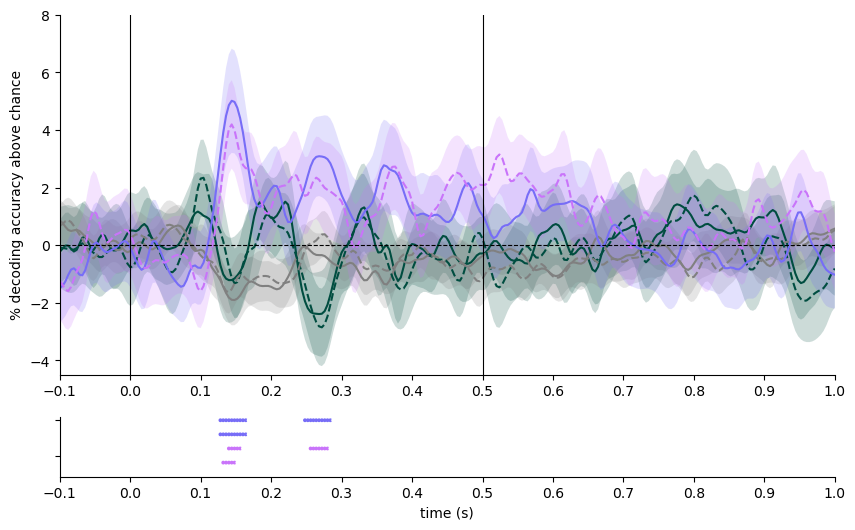

In [6]:
colors = ['#004D40','grey','#004D40','grey','#776DF7','#C974FA']
colors_p = ['#776DF7','#776DF7','#C974FA','#C974FA']
markers = ['-','-','--','--','-','--']
arrays = [pvals_plot_diff_al_within,pvals_plot_diff_al_between,pvals_plot_diff_la_within,pvals_plot_diff_la_between,None,None]
smooth_scores = [smooth_for_plot(diff_al_control_within_scene),
                 smooth_for_plot(diff_al_control_between_scene),
                smooth_for_plot(diff_la_control_within_scene),
                smooth_for_plot(diff_la_control_between_scene),
                smooth_for_plot(diff_al),
                smooth_for_plot(diff_la)]
fig, ax_main, ax_sub = plot_arrays_and_scores(arrays, smooth_scores, epochs, colors, markers, colors_p)
plt.yticks(ticks=range(-4, 8, 2))
ax_main.set_ylim(top=8, bottom=-4.5)
ax_sub.set_ylim(-4*0.8,0.2)
plt.savefig(f'../results/plots/CrossDecodingPhrase-PCA_{pca}-{estimator}_within_between.png', dpi=300)

### 6. Cross-Decoding Scene

In [38]:
cond="scene"
direction_flag="CrossAnchorLocal_Scene"
scores = []
for sub in range(25):
    fname = f'../data/sub-{str(sub+1).zfill(2)}/cross_decoding/{direction_flag}/{cond}/{estimator}/pca_{pca}/{str(sub+1).zfill(2)}-{direction_flag}-Decoding-Acc-pseudo-diagtimes-PCA_{pca}-{estimator}.npy'
    scores.append(np.load(fname))
scores = np.stack(scores)
diff_al = scores-1/2
pvals_plot_al, c_al = compute_p_values(diff_al, return_clusters=True)
[np.save(f"../results/good_clusters-al_scene-diagtimes-PCA_{pca}-{estimator}-{x+1}.npy", c_al[x]) for x in range(len(c_al))]

direction_flag="CrossLocalAnchor_Scene"
scores = []
for sub in range(25):
    fname = f'../data/sub-{str(sub+1).zfill(2)}/cross_decoding/{direction_flag}/{cond}/{estimator}/pca_{pca}/{str(sub+1).zfill(2)}-{direction_flag}-Decoding-Acc-pseudo-diagtimes-PCA_{pca}-{estimator}.npy'
    scores.append(np.load(fname))
scores = np.stack(scores)
diff_la = scores-1/2
pvals_plot_la, c_la = compute_p_values(diff_la, return_clusters=True)
[np.save(f"../results/good_clusters-la_scene-diagtimes-PCA_{pca}-{estimator}-{x+1}.npy", c_la[x]) for x in range(len(c_la))]

diff = diff_al-diff_la
pvals_plot_diff = compute_p_values(diff)

Using a threshold of 1.710882
stat_fun(H1): min=-2.8876958453889183 max=3.995755066192493
Running initial clustering …
Found 22 clusters


  0%|          | Permuting : 0/9999 [00:00<?,       ?it/s]

Using a threshold of 1.710882
stat_fun(H1): min=-2.3226283559669305 max=4.131670220973033
Running initial clustering …
Found 28 clusters


  0%|          | Permuting : 0/9999 [00:00<?,       ?it/s]

Using a threshold of 1.710882
stat_fun(H1): min=-2.8641560415781253 max=2.8091465515038707
Running initial clustering …
Found 7 clusters


  0%|          | Permuting : 0/9999 [00:00<?,       ?it/s]

In [39]:
# significant clusters
[epochs.times[x] for x in c_al]# select configuration

[array([0.128, 0.132, 0.136, 0.14 , 0.144, 0.148, 0.152, 0.156, 0.16 ,
        0.164, 0.168, 0.172])]

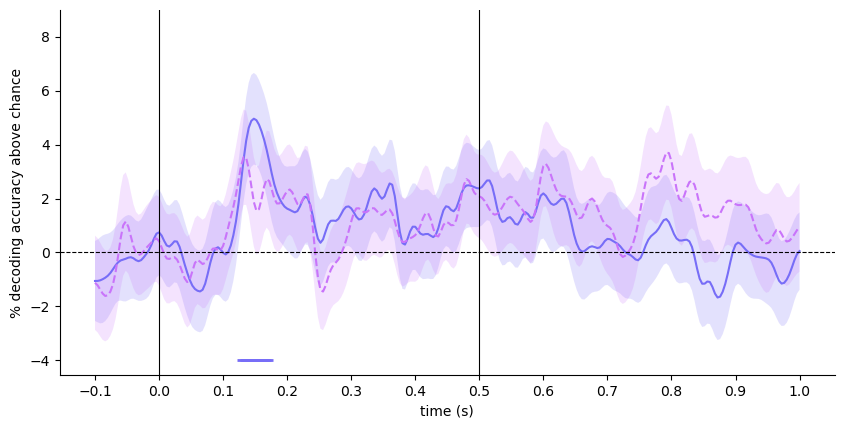

In [40]:
pvals_plot_al[np.where(pvals_plot_al)] = -4
pvals_plot_la[np.where(pvals_plot_la)] = -4.5

fig, ax = plt.subplots(figsize = (10,5))

ga_scores_al, sigma_al = smooth_for_plot(diff_al)
ga_scores_la, sigma_la = smooth_for_plot(diff_la)
ga_scores_al_control, sigma_al_control = smooth_for_plot(diff_al_control)
ga_scores_la_control, sigma_la_control = smooth_for_plot(diff_la_control)

ax.plot(epochs.times, ga_scores_al, color='#776DF7', linestyle="-")
ax.fill_between(epochs.times, ga_scores_al+sigma_al, ga_scores_al-sigma_al, facecolor='#776DF7', alpha=0.2)

ax.plot(epochs.times, ga_scores_la, color='#C974FA', linestyle="--")
ax.fill_between(epochs.times, ga_scores_la+sigma_la, ga_scores_la-sigma_la, facecolor='#C974FA', alpha=0.2)

ax.scatter(epochs.times, pvals_plot_al, c="#776DF7", marker="_",linewidths=2)
ax.scatter(epochs.times, pvals_plot_la, c="#C974FA", marker="_",linewidths=2)

add_plot_configs()

plt.yticks(ticks=range(-4,10,2))
ax.set_ylim(top=9)
plt.savefig(f'../results/plots/CrossDecodingScene-PCA_{pca}-{estimator}.png', dpi=300)